In [458]:
import pandas as pd
import seaborn as seaborn
import statistics
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import AnchoredText
import os

In [2]:
Path_abund=pd.read_csv("Merged_Pathabundance_Table_CPM_meta.tsv",delimiter='\t')
Mapping_dict={}
for i in range(Path_abund.shape[0]):
    Mapping_dict['X'+str(i)]=Path_abund.iloc[i,0]
    Path_abund.iloc[i,0]='X'+str(i)
    
Path_abund.set_index(['Sample_ID'],inplace=True)
Path_abund.to_csv("Path_abundance_Temp.tsv")


In [3]:
Sig_Results=pd.read_csv("./Pathways_MaAslin/significant_results.tsv",delimiter="\t")
Filter_By_pval=(Sig_Results['pval']<0.05)&(Sig_Results['qval']<0.05)
Sig_Results= Sig_Results.loc[Filter_By_pval]

Now, lets remove any pathway that is correlated with sex:

In [4]:
Sex_Correlated=list(Sig_Results[Sig_Results['metadata']=='Sex']['feature'])
Sig_Results=Sig_Results[~Sig_Results['feature'].isin(Sex_Correlated)]

In [5]:
Path_abund=Path_abund.reset_index()


In [6]:
Path_Abund_Filtered=Path_abund[Path_abund["Sample_ID"].isin(Sig_Results["feature"])]
Path_Abund_Filtered=Path_Abund_Filtered.reset_index(drop=True)


In [7]:
for i in range(Path_Abund_Filtered.shape[0]):
       Path_Abund_Filtered.loc[i,"Sample_ID"]=Mapping_dict[Path_Abund_Filtered.loc[i,"Sample_ID"]]
Path_Abund_Filtered

,Sample_ID,Control_327,Control_328,Control_330,DSS_334,DSS_339,DSS_treatedp,D_Control,D_DSS,D_RCE,D_RCE_plus_DSS,RCE_318,RCE_319,RCE_322,RCE_plus_DSS_301,RCE_plus_DSS_305,RCE_plus_DSS_313,Start
0,UNINTEGRATED|g__Anaerotruncus.s__Anaerotruncus...,2209.720000,806.961000,1466.140000,0.000000,0.000000,0.00000,1150.940000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1459.160000
1,UNINTEGRATED|g__Bacteroides.s__Bacteroides_cae...,1457.060000,2931.060000,1888.640000,14091.300000,38722.900000,7306.65000,5068.930000,32309.700000,9277.03000,34711.400000,5342.990000,4583.260000,2888.890000,6105.400000,10933.40000,7245.98000,3842.750000
2,UNINTEGRATED|g__Clostridium.s__Clostridium_sp_...,3491.230000,1568.850000,1059.070000,0.000000,0.000000,1383.94000,0.000000,1095.980000,0.00000,1910.460000,0.000000,0.000000,0.000000,3769.150000,4259.54000,0.00000,0.000000
3,UNINTEGRATED|g__Dorea.s__Dorea_sp_5_2,4201.000000,5367.550000,4113.870000,0.000000,0.000000,0.00000,1495.060000,0.000000,0.00000,447.688000,0.000000,1660.430000,3252.700000,1869.830000,3068.41000,0.00000,0.000000
4,UNINTEGRATED|g__Lactobacillus.s__Lactobacillus...,1127.220000,697.283000,251.356000,0.000000,0.000000,0.00000,97.420500,0.000000,10.70520,0.000000,0.000000,26.030400,0.000000,0.000000,0.00000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,TRNA-CHARGING-PWY: tRNA charging|g__Muribacula...,19.959500,13.742300,9.288840,0.000000,0.000000,0.00000,11.155900,0.000000,15.16890,0.000000,7.483740,5.801200,6.493200,0.000000,0.00000,0.00000,14.294500
211,UDPNAGSYN-PWY: UDP-N-acetyl-D-glucosamine bios...,1.619220,1.125010,0.855321,0.000000,0.319205,0.00000,0.561899,0.776336,0.00000,0.640989,0.000000,0.000000,0.000000,0.684882,0.00000,0.00000,0.000000
212,VALSYN-PWY: L-valine biosynthesis|g__Alistipes...,0.000000,0.000000,0.000000,0.997673,5.904690,1.34306,0.000000,2.089740,0.98305,2.852110,0.477253,0.672997,0.506535,0.476168,1.03415,3.74929,0.477856
213,VALSYN-PWY: L-valine biosynthesis|g__Bacteroid...,0.571982,0.533156,0.000000,11.635800,6.491870,6.85650,2.460700,13.550900,8.63931,8.663340,2.677510,0.000000,1.079250,5.689090,3.16522,6.29814,3.384350


In [8]:
Path_Abund_Unstratified_Filtered=Path_Abund_Filtered[~Path_Abund_Filtered['Sample_ID'].str.contains('|',regex=False)]
Path_Abund_Unstratified_Filtered=Path_Abund_Unstratified_Filtered.reset_index(drop=True)
Sig_Results.set_index("feature",inplace=True)

In [9]:
os.mkdir('Sig_Plots_Pathways/')
for i in range(Path_Abund_Unstratified_Filtered.shape[0]):
    x=[1,1,1,3,3,5,5,5,7,7,7]
    x1=list(np.linspace(0.5,1.5,100))
    x2=list(np.linspace(2.5,3.5,100))
    x3=list(np.linspace(4.5,5.5,100))
    x4=list(np.linspace(6.5,7.5,100))
    x5=[1,3,3,5,7]
    y=list(Path_Abund_Unstratified_Filtered.iloc[i,[1,2,3,4,5,11,12,13,14,15,16]])
    y1=[statistics.median(y[0:3])]*len(x1)
    y2=[statistics.median(y[3:5])]*len(x1)
    y3=[statistics.median(y[5:8])]*len(x1)
    y4=[statistics.median(y[8:11])]*len(x1)
    y5=Path_Abund_Unstratified_Filtered.iloc[i,[6,7,8,9,10]]
    plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,color='k',linewidth=1,linestyle="--")
    plt.scatter(x,y,s=25,cmap='summer')
    plt.scatter(x5,y5,s=30,cmap='r',marker=',')
    plt.suptitle(Path_Abund_Unstratified_Filtered.loc[i,"Sample_ID"],fontsize=7)
    plt.xticks([1,3,5,7],['Control','DSS','RCE','RCE+DSS'])
    for keys in Mapping_dict:
        if Mapping_dict[keys]==Path_Abund_Unstratified_Filtered.loc[i,"Sample_ID"]:
            Temp=keys
    top_DSS=plt.ylim()[1]-1
    if len(Sig_Results.loc[Temp].shape)==1:     
        plt.text(6,top_DSS,Sig_Results.loc[Temp,"metadata"]+": " + str(Sig_Results.loc[Temp,"value"])+"\n\nCoeff: "+ str(Sig_Results.loc[Temp,"coef"])[0:5]+"\n\nP_value: "+str(format(Sig_Results.loc[Temp,"pval"],'f'))+"\n\nQ_value: "+str(format(Sig_Results.loc[Temp,"qval"],'f')),fontsize=7,verticalalignment="top")
    else:
        plt.text(6,top_DSS,"DSS_Only:"+ str(Sig_Results.loc[Temp,"value"].iloc[0])+"\n\nCoeff: "+ str(Sig_Results.loc[Temp,"coef"].iloc[0])[0:5]+"\n\nP_value: "+str(format(Sig_Results.loc[Temp,"pval"].iloc[0],'f'))+"\n\nQ_value: "+str(format(Sig_Results.loc[Temp,"qval"].iloc[0],'f')),fontsize=7,verticalalignment="top")
    plt.xlabel("Treatment Group")
    plt.ylabel("Path Abundances")
    plt.savefig("Sig_Plots_Pathways/"+Path_Abund_Unstratified_Filtered.loc[i,"Sample_ID"][0:15].replace(': ','')+'.png',dpi=300)
    plt.cla()

FileExistsError: [Errno 17] File exists: 'Sig_Plots_Pathways/'

In [ ]:
Path_Abund_Unstratified_Filtered.loc[i,"Sample_ID"][0:15].strip(' ')

In [ ]:
Path_Abund_Unstratified_Filtered.set_index("Sample_ID",inplace=True)

In [ ]:
import seaborn
ax=seaborn.clustermap(Path_Abund_Unstratified_Filtered,standard_scale=0,figsize=(25,15),row_cluster=False, metric="correlation",dendrogram_ratio=(.1, .2),cbar_pos=(0, .2, .03, .4))
ax.savefig("test")

In [ ]:
Path_Abund_Unstratified_Filtered.reset_index(inplace=True)

In [ ]:
Sig_Results.reset_index(inplace=True)
for i in range(Sig_Results.shape[0]):
    Sig_Results['feature'][i]=Mapping_dict[Sig_Results['feature'][i]]
    

In [ ]:
import math
import numpy

In [ ]:
Path_Abund_Unstratified_Filtered.reset_index(inplace=True)

In [ ]:
Sig_Results.set_index("feature",inplace=True)

In [ ]:
Heatmap_Dict={"Pathway":[],"DSS_only":[],"RCE_only":[],"RCEwDSS_only":[]}
DF=pd.DataFrame(Heatmap_Dict)
Counter=0
for i in Path_Abund_Unstratified_Filtered["Sample_ID"]:
    DF.loc[Counter]=[i,0,0,0]
    Temp=Sig_Results.loc[i,['metadata','coef','qval']]
    if len(Temp.shape)==1:
        DF.loc[Counter,Temp['metadata']]=-numpy.log(Temp['qval'])*numpy.sign(Temp['coef'])
    else:
        for k in range(Temp.shape[0]):
            DF.loc[Counter,Temp['metadata'][k]]=-numpy.log(Temp['qval'][k])*numpy.sign(Temp['coef'][k])
    Counter+=1
        
    
    

In [ ]:
DF.set_index('Pathway',inplace=True)

In [ ]:
T=seaborn.color_palette("coolwarm", as_cmap=True)


In [10]:
seaborn.set(rc = {'figure.figsize':(25,12)})

ax=seaborn.heatmap(DF,cmap=T,linewidths=0.1, linecolor='white',square=True)
ax=ax.get_figure()    


ax.savefig('Correlated_Pathways')

    


NameError: name 'DF' is not defined

In [11]:
Samples=list(Path_Abund_Unstratified_Filtered.columns)
Group_Names=["Control","RCE","DSS","RCE_plus_DSS","Start"]
Group_List=[]
for i in Samples:
    for j in Group_Names:
        if j in i and 'plus' not in i:
            Group_List.append(j)
            break
        elif "plus" in i:
            Group_List.append("RCE_plus_DSS")
            break

Group_List

['Control',
 'Control',
 'Control',
 'DSS',
 'DSS',
 'DSS',
 'Control',
 'DSS',
 'RCE',
 'RCE_plus_DSS',
 'RCE',
 'RCE',
 'RCE',
 'RCE_plus_DSS',
 'RCE_plus_DSS',
 'RCE_plus_DSS',
 'Start']

In [12]:
Path_Abund_Stratified_Filtered=Path_Abund_Filtered[Path_Abund_Filtered['Sample_ID'].str.contains('|',regex=False)]
Path_Abund_Stratified_Filtered=Path_Abund_Stratified_Filtered.reset_index(drop=True)
Sig_Results=Sig_Results[Sig_Results['metadata']=='DSS_only']


In [13]:
os.mkdir('Sig_Plots_Pathways_Stratified/')
for i in range(Path_Abund_Stratified_Filtered.shape[0]):
    x=[1,1,1,3,3,5,5,5,7,7,7]
    x1=list(np.linspace(0.5,1.5,100))
    x2=list(np.linspace(2.5,3.5,100))
    x3=list(np.linspace(4.5,5.5,100))
    x4=list(np.linspace(6.5,7.5,100))
    x5=[1,3,3,5,7]
    y=list(Path_Abund_Stratified_Filtered.iloc[i,[1,2,3,4,5,11,12,13,14,15,16]])
    y1=[statistics.median(y[0:3])]*len(x1)
    y2=[statistics.median(y[3:5])]*len(x1)
    y3=[statistics.median(y[5:8])]*len(x1)
    y4=[statistics.median(y[8:11])]*len(x1)
    y5=Path_Abund_Stratified_Filtered.iloc[i,[6,7,8,9,10]]
    plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,color='k',linewidth=1,linestyle="--")
    plt.scatter(x,y,s=25,cmap='summer')
    plt.scatter(x5,y5,s=30,cmap='r',marker=',')
    plt.suptitle(Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"],fontsize=7)
    plt.xticks([1,3,5,7],['Control','DSS','RCE','RCE+DSS'])
    for keys in Mapping_dict:
        if Mapping_dict[keys]==Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"]:
            Temp=keys
    top_DSS=plt.ylim()[1]-1
    plt.text(6,top_DSS,"DSS_Only:"+ str(Sig_Results.loc[Temp,"value"].iloc[0])+"\n\nCoeff: "+ str(Sig_Results.loc[Temp,"coef"].iloc[0])[0:5]+"\n\nP_value: "+str(format(Sig_Results.loc[Temp,"pval"].iloc[0],'f'))+"\n\nQ_value: "+str(format(Sig_Results.loc[Temp,"qval"].iloc[0],'f')),fontsize=7,verticalalignment="top")
    plt.xlabel("Treatment Group")
    plt.ylabel("Path Abundances")
    plt.savefig("Sig_Plots_Pathways_Stratified/"+Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"][0:6],dpi=300)
    plt.cla()

FileExistsError: [Errno 17] File exists: 'Sig_Plots_Pathways_Stratified/'

In [14]:
Rxn_abund=pd.read_csv("./rxn-cpm.txt",delimiter='\t')
Mapping_dict={}
for i in range(Rxn_abund.shape[0]):
    Mapping_dict['X'+str(i)]=Rxn_abund.iloc[i,0]
    Rxn_abund.iloc[i,0]='X'+str(i)
  
Rxn_abund.set_index(['Sample_ID'],inplace=True)
Rxn_abund.to_csv("Rxn_abundance_Temp.tsv")

In [15]:
Sig_Results=pd.read_csv("./Rxns_MaAslin/significant_results.tsv",delimiter="\t")
Filter_By_pval=(Sig_Results['pval']<0.05)&(Sig_Results['qval']<0.05)
Sig_Results= Sig_Results.loc[Filter_By_pval]

In [16]:
Sex_Correlated=list(Sig_Results[Sig_Results['metadata']=='Sex']['feature'])
Sig_Results=Sig_Results[~Sig_Results['feature'].isin(Sex_Correlated)]

In [17]:
Rxn_abund.reset_index(inplace=True)

In [18]:
Rxn_Abund_Filtered=Rxn_abund[Rxn_abund["Sample_ID"].isin(Sig_Results["feature"])]          
Rxn_Abund_Filtered=Rxn_Abund_Filtered.reset_index(drop=True)

In [19]:
for i in range(Rxn_Abund_Filtered.shape[0]):
       Rxn_Abund_Filtered.loc[i,"Sample_ID"]=Mapping_dict[Rxn_Abund_Filtered.loc[i,"Sample_ID"]]
Rxn_Abund_Filtered

,Sample_ID,Control_327,Control_328,Control_330,DSS_334,DSS_339,DSS_treatedp,D_Control,D_DSS,D_RCE,D_RCE_plus_DSS,RCE_318,RCE_319,RCE_322,RCE_plus_DSS_301,RCE_plus_DSS_305,RCE_plus_DSS_313,Start
0,UNGROUPED|g__Bacteroides.s__Bacteroides_caecim...,1667.326255,3625.450957,2522.720216,13997.820610,36407.795960,10244.252350,6007.550322,27716.729600,7187.943313,32524.294300,4806.404374,4681.872176,3366.492410,6802.362918,10373.103980,9478.877585,4890.110247
1,UNGROUPED|g__Bacteroides.s__Bacteroides_vulgatus,0.000000,0.000000,0.000000,9681.620297,7712.722426,5024.388154,0.000000,9110.922297,6630.227268,7047.215860,0.000000,0.000000,0.000000,4754.958269,3021.292134,6111.360978,4020.174215
2,UNGROUPED|g__Bacteroides.s__Bacteroides_vulgat...,0.000000,0.000000,0.000000,254.511207,137.497821,113.784579,0.000000,269.676771,181.796462,178.288027,0.000000,0.000000,0.000000,95.288877,63.872390,110.094786,73.483841
3,UNGROUPED|g__Dorea.s__Dorea_sp_5_2,4807.377218,1787.789545,2833.233994,1021.091537,0.000000,0.000000,1640.490544,0.000000,0.000000,2074.596797,1727.657318,2321.174056,1800.029613,4136.227050,5964.212363,3065.928555,1172.322870
4,UNGROUPED|g__Lactobacillus.s__Lactobacillus_in...,1572.041903,1044.689807,425.471865,0.000000,0.000000,0.000000,121.241479,0.000000,57.910897,0.000000,0.000000,71.561624,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287,XYLISOM-RXN|g__Alistipes.s__Alistipes_timonensis,0.000000,0.000000,0.000000,4.609650,5.974310,6.397120,0.000000,4.055550,1.194570,7.477030,4.661260,5.431870,0.884835,3.262840,1.065650,5.076930,2.227570
3288,XYLISOM-RXN|g__Bacteroides.s__Bacteroides_caec...,0.321202,1.324450,0.793821,5.229390,11.596600,5.475310,2.385140,9.106850,2.596200,12.804200,0.989656,1.745940,0.784983,2.914620,3.208790,4.761860,1.934090
3289,XYLISOM-RXN|g__Bacteroides.s__Bacteroides_vulg...,0.000000,0.000000,0.000000,0.225149,0.063949,0.070266,0.000000,0.016205,0.028442,0.012765,0.000000,0.000000,0.000000,0.043165,0.017435,0.083297,0.027275
3290,XYLISOM-RXN|g__Bacteroides.s__Bacteroides_vulg...,0.000000,0.000000,0.000000,0.067741,0.047972,0.018039,0.000000,0.080928,0.042662,0.038284,0.000000,0.000000,0.000000,0.014612,0.000000,0.016631,0.027229


In [20]:
Rxn_Abund_Unstratified_Filtered=Rxn_Abund_Filtered[~Rxn_Abund_Filtered['Sample_ID'].str.contains('|',regex=False)]
Rxn_Abund_Unstratified_Filtered=Rxn_Abund_Unstratified_Filtered.reset_index(drop=True)
Sig_Results.set_index("feature",inplace=True)

In [21]:
Rxn_Abund_Unstratified_Filtered

,Sample_ID,Control_327,Control_328,Control_330,DSS_334,DSS_339,DSS_treatedp,D_Control,D_DSS,D_RCE,D_RCE_plus_DSS,RCE_318,RCE_319,RCE_322,RCE_plus_DSS_301,RCE_plus_DSS_305,RCE_plus_DSS_313,Start
0,1.1.1.261-RXN,0.518883,0.571223,0.344672,4.920670,14.198800,2.007661,0.862320,10.712645,2.279785,12.054140,1.280553,1.167721,0.756866,4.289825,7.677280,1.855718,0.688580
1,1.2.3.3-RXN,0.950802,0.539132,0.324664,0.000000,0.000000,0.000000,0.181543,0.159444,0.520051,0.116714,0.000000,0.270876,0.165698,0.256403,0.244155,0.000000,0.105541
2,1.8.1.4-RXN,26.163215,29.238519,15.825367,61.619609,53.929604,36.483423,33.565816,59.512336,60.375976,57.309128,41.822537,42.720958,35.959189,37.542914,34.866559,37.100136,34.809058
3,1.8.98.1-RXN,0.000000,0.055528,0.000000,1.592570,3.129480,1.872640,0.117682,2.655730,0.410431,3.505530,1.055630,1.349320,0.184644,0.417077,0.545690,2.196670,0.282592
4,2-DEHYDROPANTOATE-REDUCT-RXN,8.607375,8.213841,6.149367,18.582591,25.334890,13.701469,11.477449,30.708384,19.980193,30.284354,9.452800,7.851353,10.383391,14.182464,15.448174,20.231934,10.952632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,TRANS-HEXAPRENYLTRANSTRANSFERASE-RXN,2.091533,1.538541,1.312545,0.432451,0.000000,0.000000,0.855360,0.866214,0.869936,1.147844,0.360322,1.564712,0.491992,1.221006,1.379123,0.862832,0.685210
298,TRANS-RXN0-623,3.528017,4.589247,2.590422,26.399576,35.841531,17.827387,13.536245,28.139385,16.437162,30.235197,9.856272,13.394665,6.739349,14.561609,14.806337,18.561401,9.698030
299,TRYPTOPHAN-RXN,1.263107,1.033340,2.586960,27.159280,28.938444,16.261760,3.450558,13.537443,2.230817,19.237515,3.236824,8.663790,3.277521,14.202670,19.490370,13.880300,2.838568
300,TYROSINE-PHENOL-LYASE-RXN,0.703641,0.239769,0.398695,4.754980,6.327741,6.157500,1.135197,6.230810,0.631704,7.916130,1.282288,2.617062,1.112916,2.618478,1.933610,4.431434,1.161321


In [22]:
os.mkdir('Sig_Plots_Rxns/')
for i in range(Rxn_Abund_Unstratified_Filtered.shape[0]):
    x=[1,1,1,3,3,5,5,5,7,7,7]
    x1=list(np.linspace(0.5,1.5,100))
    x2=list(np.linspace(2.5,3.5,100))
    x3=list(np.linspace(4.5,5.5,100))
    x4=list(np.linspace(6.5,7.5,100))
    x5=[1,3,3,5,7]
    y=list(Rxn_Abund_Unstratified_Filtered.iloc[i,[1,2,3,4,5,11,12,13,14,15,16]])
    y1=[statistics.median(y[0:3])]*len(x1)
    y2=[statistics.median(y[3:5])]*len(x1)
    y3=[statistics.median(y[5:8])]*len(x1)
    y4=[statistics.median(y[8:11])]*len(x1)
    y5=Rxn_Abund_Unstratified_Filtered.iloc[i,[6,7,8,9,10]]
    plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,color='k',linewidth=1,linestyle="--")
    plt.scatter(x,y,s=25,cmap='summer')
    plt.scatter(x5,y5,s=30,cmap='r',marker=',')
    plt.suptitle(Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"],fontsize=7)
    plt.xticks([1,3,5,7],['Control','DSS','RCE','RCE+DSS'])
    for keys in Mapping_dict:
        if Mapping_dict[keys]==Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"]:
            Temp=keys
    top_DSS=plt.ylim()[1]-1
    for keys in Mapping_dict:
        if Mapping_dict[keys]==Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"]:
            Temp=keys
    top_DSS=plt.ylim()[1]-1
    if len(Sig_Results.loc[Temp].shape)==1:     
        plt.text(6,top_DSS,Sig_Results.loc[Temp,"metadata"]+": " + str(Sig_Results.loc[Temp,"value"])+"\n\nCoeff: "+ str(Sig_Results.loc[Temp,"coef"])[0:5]+"\n\nP_value: "+str(format(Sig_Results.loc[Temp,"pval"],'f'))+"\n\nQ_value: "+str(format(Sig_Results.loc[Temp,"qval"],'f')),fontsize=7,verticalalignment="top")
    else:
        plt.text(6,top_DSS,Sig_Results.loc[Temp,"metadata"].iloc[0]+ str(Sig_Results.loc[Temp,"value"].iloc[0])+"\n\nCoeff: "+ str(Sig_Results.loc[Temp,"coef"].iloc[0])[0:5]+"\n\nP_value: "+str(format(Sig_Results.loc[Temp,"pval"].iloc[0],'f'))+"\n\nQ_value: "+str(format(Sig_Results.loc[Temp,"qval"].iloc[0],'f')),fontsize=7,verticalalignment="top")
    plt.xlabel("Treatment Group")
    plt.ylabel("Path Abundances")
    plt.savefig("Sig_Plots_Rxns/"+Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"][0:20].replace(': ','')+'.png',dpi=300)
    plt.cla()

FileExistsError: [Errno 17] File exists: 'Sig_Plots_Rxns/'

In [ ]:
Sig_Results.reset_index(inplace=True)
for i in range(Sig_Results.shape[0]):
    Sig_Results.loc[i,"feature"]=Mapping_dict[Sig_Results.loc[i,"feature"]]
Sig_Results=Sig_Results[~Sig_Results['feature'].str.contains('|',regex=False)]
Sig_Results.reset_index(drop=True,inplace=True)
Sig_Results.set_index('feature',inplace=True)

In [ ]:
Heatmap_Dict={"Rxn":[],"DSS_only":[],"RCE_only":[],"RCEwDSS_only":[]}
DF=pd.DataFrame(Heatmap_Dict)
Counter=0
for i in Rxn_Abund_Unstratified_Filtered["Sample_ID"]:
    DF.loc[Counter]=[i,0,0,0]
    Temp=Sig_Results.loc[i,['metadata','coef','qval']]
    if len(Temp.shape)==1:
        DF.loc[Counter,Temp['metadata']]=-np.log(Temp['qval'])*np.sign(Temp['coef'])
    else:
        for k in range(Temp.shape[0]):
            DF.loc[Counter,Temp['metadata'][k]]=-np.log(Temp['qval'][k])*np.sign(Temp['coef'][k])
    Counter+=1
DF.set_index("Rxn",inplace=True)

In [ ]:
import math
from matplotlib.pyplot import figure


In [ ]:
for i in range(math.floor(DF.shape[0]/20)):
    if (i+1)*20<DF.shape[0]:
        ax=seaborn.heatmap(DF.iloc[20*i:20*(i+1)],cmap=T,linewidths=1, linecolor='white',square=True)

    else:
        ax=seaborn.heatmap(DF.iloc[20*i:],cmap=T,linewidths=1, linecolor='white',square=True)

    ax=ax.get_figure()    
    ax.savefig('Rxn_Heatmap'+str(i))
    plt.clf()
    

In [ ]:
Rxn_Abund_Stratified_Filtered=Rxn_Abund_Filtered[Rxn_Abund_Filtered['Sample_ID'].str.contains('|',regex=False)]
Rxn_Abund_Stratified_Filtered=Rxn_Abund_Stratified_Filtered.reset_index(drop=True)
Sig_Results=Sig_Results[Sig_Results['metadata']=='DSS_only']



In [ ]:
os.mkdir('Sig_Plots_Stratified_Rxns/')
for i in range(Rxn_Abund_Stratified_Filtered.shape[0]):
    x=[1,1,1,3,3,5,5,5,7,7,7]
    x1=list(np.linspace(0.5,1.5,100))
    x2=list(np.linspace(2.5,3.5,100))
    x3=list(np.linspace(4.5,5.5,100))
    x4=list(np.linspace(6.5,7.5,100))
    x5=[1,3,3,5,7]
    y=list(Rxn_Abund_Stratified_Filtered.iloc[i,[1,2,3,4,5,11,12,13,14,15,16]])
    y1=[statistics.median(y[0:3])]*len(x1)
    y2=[statistics.median(y[3:5])]*len(x1)
    y3=[statistics.median(y[5:8])]*len(x1)
    y4=[statistics.median(y[8:11])]*len(x1)
    y5=Rxn_Abund_Stratified_Filtered.iloc[i,[6,7,8,9,10]]
    plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,color='k',linewidth=1,linestyle="--")
    plt.scatter(x,y,s=25,cmap='summer')
    plt.scatter(x5,y5,s=30,cmap='r',marker=',')
    plt.suptitle(Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"],fontsize=7)
    plt.xticks([1,3,5,7],['Control','DSS','RCE','RCE+DSS'])
    for keys in Mapping_dict:
        if Mapping_dict[keys]==Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"]:
            Temp=keys
    top_DSS=plt.ylim()[1]-1
    plt.text(6,top_DSS,"DSS_Only:"+ str(Sig_Results.loc[Temp,"value"])+"\n\nCoeff: "+ str(Sig_Results.loc[Temp,"coef"])[0:5]+"\n\nP_value: "+str(format(Sig_Results.loc[Temp,"pval"],'f'))+"\n\nQ_value: "+str(format(Sig_Results.loc[Temp,"qval"],'f')),fontsize=7,verticalalignment="top")
    plt.xlabel("Treatment Group")
    plt.ylabel("Path Abundances")
    plt.savefig("Sig_Plots_Rxns/"+Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"][0:6]+'.png',dpi=300)
    plt.cla()

In [23]:
Sig_Results.reset_index(inplace=True)
for i in range(Sig_Results.shape[0]):
    Sig_Results.loc[i,"feature"]=Mapping_dict[Sig_Results.loc[i,"feature"]]

In [24]:
Sig_Results=Sig_Results[~Sig_Results['feature'].str.contains('|',regex=False)]

In [25]:
Sig_Results.reset_index(drop=True,inplace=True)

In [26]:
Sig_Results.set_index('feature',inplace=True)

In [27]:
Sig_Results.to_csv("Significant_Result_Rxns.csv")

In [28]:
Sig_Results

,metadata,value,coef,stderr,N,N.not.0,pval,qval
feature,,,,,,,,
RXN-12402,DSS_only,TRUE,0.642598,0.052475,12,12,0.000006,0.001680
RXN0-5001,DSS_only,TRUE,0.642598,0.052475,12,12,0.000006,0.001680
3.4.14.5-RXN,DSS_only,TRUE,0.781943,0.065821,12,12,0.000007,0.001867
3.2.1.55-RXN,DSS_only,TRUE,0.732277,0.068168,12,12,0.000013,0.002562
RXN-19757,DSS_only,TRUE,0.732277,0.068168,12,12,0.000013,0.002562
...,...,...,...,...,...,...,...,...
QUERCETIN-23-DIOXYGENASE-RXN,DSS_only,TRUE,1.493728,0.322560,12,11,0.002395,0.049308
GLCNACPTRANS-RXN,DSS_only,TRUE,0.652121,0.140970,12,12,0.002409,0.049480
GLUTAMATE-SYNTHASE-NADH-RXN,DSS_only,TRUE,-0.850692,0.183928,12,7,0.002411,0.049499


## Some Further Analysis

Tables Needed:

- Path_Abund_Stratified_Filtered
- Rxn_Abund_Unstratified_Filtered
- Path_Abund_Unstratified_Filtered

**Question 1:**

-	Several reactions that look apparently higher in DSS+RCJ but low in DSS and controlonly are alpha-L-focusidase: 
        - ALPHA-L-FOCUSIDEASE 
        - RXN-19378
        - RXN-19379
        - The figures all look the same, so they are probably from the same gene
        - Can you check if this gene/reaction is significantly higher in DSS+RCJ vs. DSS? It might not since one sample in DSS+RCJ is at the same level as DSS but two others are about 2-fold higher.


In [69]:
from scipy.stats import ttest_ind


In [67]:
Q1_List=["ALPHA","RXN-19378","RXN-19379"]
Q1_DF=Rxn_Abund_Unstratified_Filtered[Rxn_Abund_Unstratified_Filtered["Sample_ID"].str.contains("Something_Werid")]
for i in range(len(Q1_List)):
    Q1_DF=Q1_DF.append(Rxn_Abund_Unstratified_Filtered[Rxn_Abund_Unstratified_Filtered["Sample_ID"].str.contains(Q1_List[i])])
    
Q1_DF=Q1_DF.iloc[:,[4,5,-4,-3,-2]]

In [68]:
for i in 

,DSS_334,DSS_339,RCE_plus_DSS_301,RCE_plus_DSS_305,RCE_plus_DSS_313
43,1.550955,1.662367,3.201086,3.638714,1.725298
154,1.550955,1.662367,3.201086,3.638714,1.725298
155,1.550955,1.662367,3.201086,3.638714,1.725298


,Sample_ID,Control_327,Control_328,Control_330,DSS_334,DSS_339,DSS_treatedp,D_Control,D_DSS,D_RCE,D_RCE_plus_DSS,RCE_318,RCE_319,RCE_322,RCE_plus_DSS_301,RCE_plus_DSS_305,RCE_plus_DSS_313,Start
155,RXN-19379,0.472814,0.50333,0.223147,1.550955,1.662367,1.84766,3.769596,0.704896,7.209636,3.692887,0.288223,0.590099,0.901962,3.201086,3.638714,1.725298,2.00628


In [430]:
Desired_Species=["d__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Lachnospiraceae|g__Roseburia|s__Roseburia intestinalis",
                 "d__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Lachnospiraceae|g__Roseburia|s__Roseburia hominis",
                "d__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Faecalibacterium|s__Faecalibacterium prausnitzii",
                "d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia muciniphila",
                "k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_johnsonii",
                "k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pseudolongum",
                "k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_sp_1_3",
                "k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_sp_5_2",
                "k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_unclassified|s__Lachnospiraceae_bacterium_10_1",
                 "k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Acetatifactor|s__Acetatifactor_muris"
                ]

In [431]:
Metaphlan=pd.read_table("Merge_Metaphlan_Clean.tsv")
Kraken_TSS=pd.read_table("Species_TSS.csv",delimiter=",")
Kraken_CSS=pd.read_table("Species_Normalized.txt",delimiter="\t")

In [432]:
Metaphlan=Metaphlan.reindex(sorted(Metaphlan.columns), axis=1).set_index("clade_name").reset_index()
Metaphlan.drop("NCBI_tax_id",axis=1,inplace=True)

In [433]:
Met_Cols=["clade_name"]
[Met_Cols.append(colname.strip("_metaphlan_bugs_list")) for colname in Metaphlan.columns if "_metaphlan_bugs_list" in colname]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [434]:
Dict={}
for i in range(len(Metaphlan.columns)):
    Dict[Metaphlan.columns[i]]=Met_Cols[i]

Dict["Start_metaphlan_bugs_list"]="Start"
Dict["clade_name"]="Taxon"
Dict["DSS_treatedp_metaphlan_bugs_list"]="DSS_treatedp"
Dict["DSS_treatedp_metaphlan_bugs_list"]="DSS_treatedp"
Dict['D_Control_metaphlan_bugs_list']="D_Control"

Metaphlan.rename(Dict,inplace=True,axis=1)
Kraken_TSS.rename({"Taxonomy":"Taxon"},inplace=True,axis=1)

In [435]:
Final_Table=pd.DataFrame(columns = Metaphlan.columns)

In [436]:
for Bac in Desired_Species:
    if Bac in list(Metaphlan["Taxon"]):
        Final_Table=Final_Table.append(Metaphlan[Metaphlan["Taxon"]==Bac])
    else:
        Final_Table=Final_Table.append(Kraken_TSS[Kraken_TSS["Taxon"]==Bac])
        

In [437]:
Bac_Names=list([name[-1].strip("s__") for name in Final_Table["Taxon"].str.split("|")])

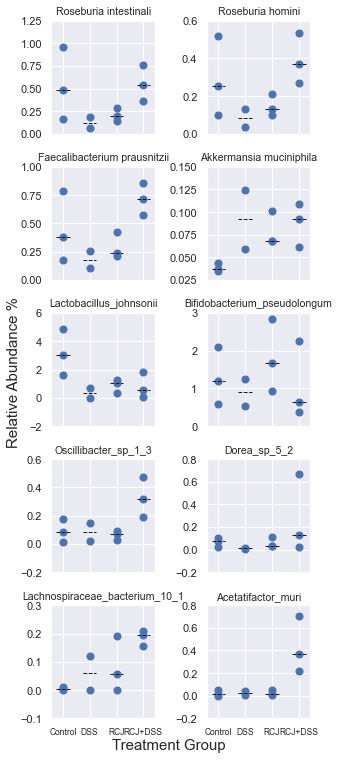

In [457]:
fig,axs=plt.subplots(int(Final_Table.shape[0]/2),2,figsize=(4.5, 10.5),sharex=True,constrained_layout=False)
for i in range(Final_Table.shape[0]):
    x=[1,1,1,3,3,5,5,5,7,7,7]
    x1=list(np.linspace(0.5,1.5,100))
    x2=list(np.linspace(2.5,3.5,100))
    x3=list(np.linspace(4.5,5.5,100))
    x4=list(np.linspace(6.5,7.5,100))
    x5=[1,3,3,5,7]
    y=list(Final_Table.iloc[i,[1,2,3,4,5,11,12,13,14,15,16]])
    y1=[statistics.median(y[0:3])]*len(x1)
    y2=[statistics.median(y[3:5])]*len(x1)
    y3=[statistics.median(y[5:8])]*len(x1)
    y4=[statistics.median(y[8:11])]*len(x1)
    y5=Final_Table.iloc[i,[6,7,8,9,10]]
    axs[math.floor(i/2),i%2].plot(x1,y1,x2,y2,x3,y3,x4,y4,color='k',linewidth=1,linestyle="--")
    axs[math.floor(i/2),i%2].scatter(x,y,s=50,cmap='summer')
#     axs[math.floor(i/2),i%2].scatter(x5,y5,s=70,cmap='r',marker=',')

    axs[math.floor(i/2),i%2].set_xticks([1,3,5,7],['Control','DSS','RCJ','RCJ+DSS'],fontsize=8.5)
    axs[math.floor(i/2),i%2].set_yticks(axs[math.floor(i/2),i%2].get_yticks(),fontsize=50)    
    axs[math.floor(i/2),i%2].set_title(Bac_Names[i],fontsize=10.5)
fig.text(0.5, 0, 'Treatment Group', ha='center',fontsize=15)
fig.text(0, 0.5, 'Relative Abundance %', va='center', rotation='vertical',fontsize=15)
fig.savefig("Taxa_of_Interest.png",dpi=600,bbox_inches="tight")

In [485]:
Desired_Items=["AMINOGLYCOSIDE-N3-ACETYLTRANSFERASE-RXN",
               "PWY-5910: superpathway of geranylgeranyldiphosphate biosynthesis I (via mevalonate)",
               "TAURINE-AMINOTRANSFERASE-RXN",
               "RXN-20702",
               "GLUDEG-I-PWY: GABA shunt|g__Lactobacillus.s__Lactobacillus_reuteri",
               "PEPTIDOGLYCANSYN-PWY: peptidoglycan biosynthesis I (meso-diaminopimelate containing)|g__Lactobacillus.s__Lactobacillus_reuteri",
               "LACTOSECAT-PWY: lactose and galactose degradation I|g__Lactobacillus.s__Lactobacillus_johnsonii"]
Item_Name=["AMINOGLYCOSIDE-N3-ACETYLTRANSFERASE".lower(),
           "superpathway of geranylgeranyldiphosphate biosynthesis",
           "TAURINE-AMINOTRANSFERASE".lower(),
           "isethionate sulfite-lyase",
          "GABA shunt: Lactobacillus_reuteri",
          "peptidoglycan biosynthesis: Lactobacillus_reuteri",
          "lactose and galactose degradation I: Lactobacillus_johnsonii"
          ]               

In [460]:
Path_abund=pd.read_csv("Merged_Pathabundance_Table_CPM_meta.tsv",delimiter='\t')
Rxn_abund=pd.read_csv("./rxn-cpm.txt",delimiter='\t')

In [463]:
Final_Table=pd.DataFrame(columns = Path_abund.columns)

In [466]:
for item in Desired_Items:
    if item in list(Path_abund["Sample_ID"]):
        Final_Table=Final_Table.append(Path_abund[Path_abund["Sample_ID"]==item])
    else:
        Final_Table=Final_Table.append(Rxn_abund[Rxn_abund["Sample_ID"]==item])
        

In [468]:
Final_Table.reset_index(inplace=True,drop=True)

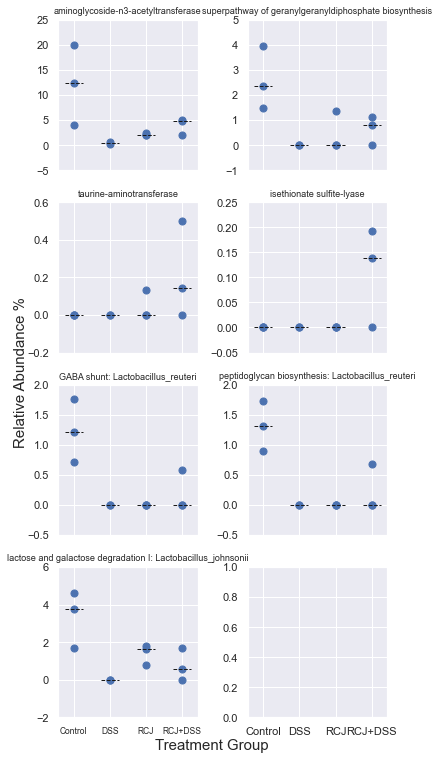

In [486]:
fig,axs=plt.subplots(int(Final_Table.shape[0]/2)+1,2,figsize=(5.5, 10.5),sharex=True,constrained_layout=False)
for i in range(Final_Table.shape[0]):
    x=[1,1,1,3,3,5,5,5,7,7,7]
    x1=list(np.linspace(0.5,1.5,100))
    x2=list(np.linspace(2.5,3.5,100))
    x3=list(np.linspace(4.5,5.5,100))
    x4=list(np.linspace(6.5,7.5,100))
    x5=[1,3,3,5,7]
    y=list(Final_Table.iloc[i,[1,2,3,4,5,11,12,13,14,15,16]])
    y1=[statistics.median(y[0:3])]*len(x1)
    y2=[statistics.median(y[3:5])]*len(x1)
    y3=[statistics.median(y[5:8])]*len(x1)
    y4=[statistics.median(y[8:11])]*len(x1)
    y5=Final_Table.iloc[i,[6,7,8,9,10]]
    axs[math.floor(i/2),i%2].plot(x1,y1,x2,y2,x3,y3,x4,y4,color='k',linewidth=1,linestyle="--")
    axs[math.floor(i/2),i%2].scatter(x,y,s=50,cmap='summer')
#     axs[math.floor(i/2),i%2].scatter(x5,y5,s=70,cmap='r',marker=',')

    axs[math.floor(i/2),i%2].set_xticks([1,3,5,7],['Control','DSS','RCJ','RCJ+DSS'],fontsize=8.5)
    axs[math.floor(i/2),i%2].set_yticks(axs[math.floor(i/2),i%2].get_yticks(),fontsize=50)    
    axs[math.floor(i/2),i%2].set_title(Item_Name[i],fontsize=9)
fig.text(0.5, 0, 'Treatment Group', ha='center',fontsize=15)
fig.text(0, 0.5, 'Relative Abundance %', va='center', rotation='vertical',fontsize=15)
fig.savefig("Rxns_of_Interest.png",dpi=600,bbox_inches="tight")

In [475]:
i

6